# Image-GAN (CS445 Project)

In this assignment, we will test three image generative adversarial networks (GAN) against threee sets of images. Each images set has different characteristics, as does each GAN.

To begin, the standard imports, as well as setting a random seed for reproducability.

In [1]:
import random

import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.autograd as autograd

import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import clear_output, display
%matplotlib inline

manualSeed = random.randint(1, 10000)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

print("Seed:", manualSeed)

Seed: 6341


## Datasets

Here, we load our three datasets. In addition, we set some global variables and intialize cuda if it is available.

The first dataset is images of mountains. This image set is quite diverse, and we expect each GAN to perform poorly in creating images that can stand in place of true photographs.

The second dataset is of dogs. While still quite diverse, this image set is less complicated in terms of general structure as we shift from mountain landscapes of all types to stills of similar animals.

The third and final dataset is of

In [2]:
# Edit to View and Create More Images

batch_size = 128
img_shape = (3, 64, 64)

# Create the Datasets

transform = transforms.Compose(
    [
        transforms.Resize(img_shape[1]),
        transforms.CenterCrop(img_shape[1]),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

dataset_mountains = dset.ImageFolder(root="../data/mountains", transform=transform)
dataset_dogs = dset.ImageFolder(root="../data/dogs", transform=transform)
dataset_three = dset.ImageFolder(root="../data/mountains", transform=transform)

dataloader_mountains = torch.utils.data.DataLoader(dataset_mountains, batch_size=batch_size, shuffle=True, num_workers=8)
dataloader_dogs = torch.utils.data.DataLoader(dataset_dogs, batch_size=batch_size, shuffle=True, num_workers=8)
dataloader_three = torch.utils.data.DataLoader(dataset_three, batch_size=batch_size, shuffle=True, num_workers=8)

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

print("Running On Cuda:", cuda)

Running On Cuda: True


## Training Images

Here are example images from each dataset.

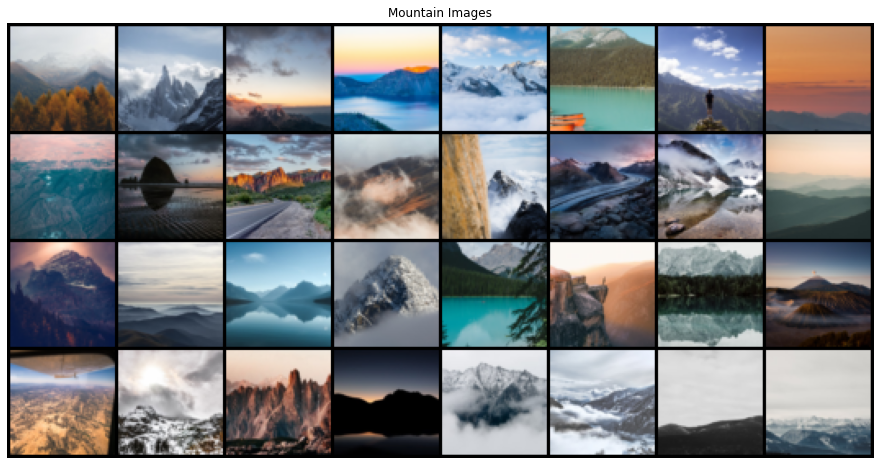

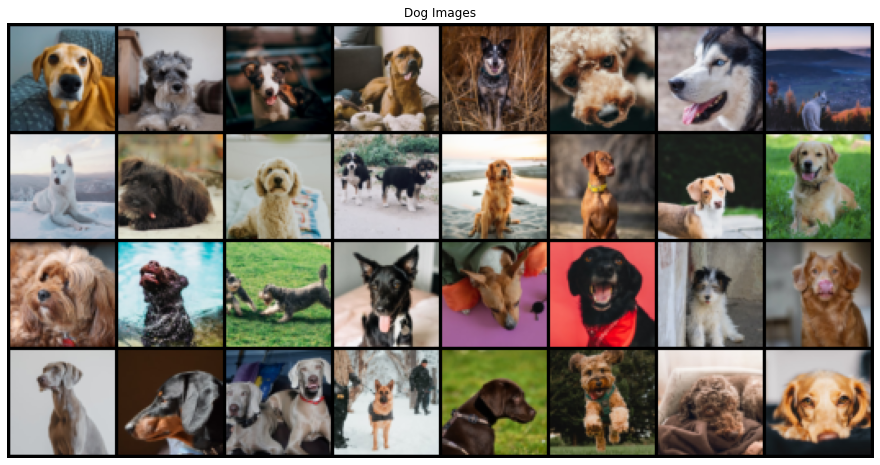

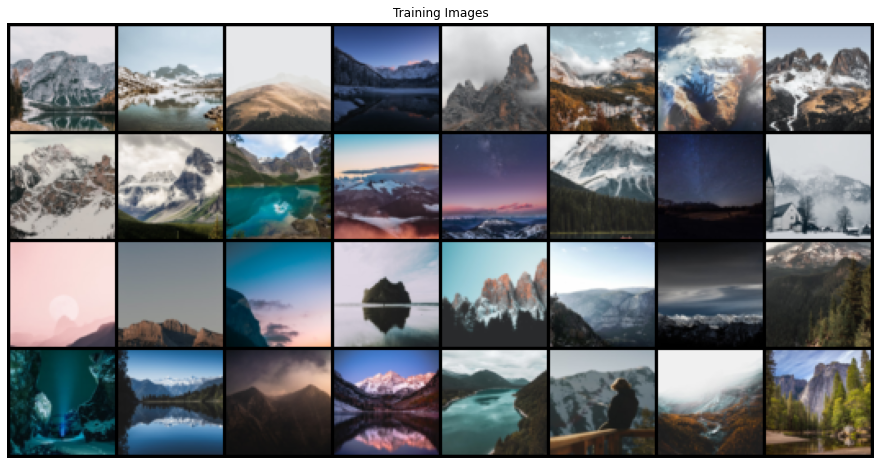

In [3]:
real_batch = next(iter(dataloader_mountains))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Mountain Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:32], padding=2, normalize=True).cpu(),(1,2,0)));

real_batch = next(iter(dataloader_dogs))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Dog Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:32], padding=2, normalize=True).cpu(),(1,2,0)));

real_batch = next(iter(dataloader_three))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:32], padding=2, normalize=True).cpu(),(1,2,0)));

## Global Functions

Here we define a few functions that we will use to give structure to this notebook. Each GAN uses a similar setup structure, so we will reuse the functions to showcase the resulting images.

In [4]:
def show_results(dataloader, img_list):
    
    real_batch = next(iter(dataloader))

    plt.figure(figsize=(16,8))
    plt.subplot(2, 1, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:32], padding=5, normalize=True).cpu(),(1,2,0)))

    plt.subplot(2, 1, 2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(vutils.make_grid(img_list[-1][:32], padding=5, normalize=True),(1,2,0)))

In [5]:
def animate_image_list(images):
    
    plt.figure(figsize=(16, 8))
    
    for epoch, img_set in enumerate(images, 1):
        
        plt.imshow(img_set[0].permute([1,2,0]))
        plt.title(f"Epoch {epoch}")
        clear_output(wait=True)
        display(plt.gcf())
    
    plt.clf()

In [6]:
def do_run(dataloader, epochs=50, show_static_results=True, verbose=True):

    netG = Generator()
    netD = Discriminator()
    
    if cuda:
        
        netG.cuda()
        netD.cuda()
        
    img_list = main_loop(dataloader, netG, netD, epochs, verbose)
    
    if show_static_results:
    
        show_results(dataloader, img_list)
        
    else:
        
        animate_image_list(img_list)

## Traditional GAN

To begin with, we attempt to run a traditional GAN on the three datasets.

In [7]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        def block(in_feat, out_feat, normalize=True):
            
            layers = [nn.Linear(in_feat, out_feat)]
            
            if normalize:
                
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
                
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        
        img = self.model(z)
        img = img.view(img.size(0), * img_shape)
        
        return img

In [8]:
class Discriminator(nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [9]:
def main_loop(dataloader, netG, netD, epochs, verbose):
    
    adversarial_loss = torch.nn.BCELoss()

    if cuda:
        
        adversarial_loss.cuda()

    optimizer_G = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

    img_list = []

    for epoch in range(epochs):
        
        for i, (imgs, _) in enumerate(dataloader):

            valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

            real_imgs = Variable(imgs.type(Tensor))

            optimizer_G.zero_grad()

            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

            gen_imgs = netG(z)
            g_loss = adversarial_loss(netD(gen_imgs), valid)

            g_loss.backward()
            optimizer_G.step()

            optimizer_D.zero_grad()

            real_loss = adversarial_loss(netD(real_imgs), valid)
            fake_loss = adversarial_loss(netD(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

        if verbose:
            
            print("[Epoch %d/%d] [Loss_D: %.4f] [Loss_G: %.4f]" % (epoch + 1, epochs, d_loss.item(), g_loss.item()), end='\r')
                                
        with torch.no_grad():

            fake = netG(z).detach().cpu()
                
        img_list.append(fake)
                            
    return img_list

In [ ]:
do_run(dataloader_mountains)

In [ ]:
do_run(dataloader_dogs)

In [ ]:
do_run(dataloader_three)

## Wasserstein GAN

The Wasserstein GAN [(paper here)](https://arxiv.org/abs/1701.07875) is a model that improves learning stability and helps get rid of problems like mode collapse, which we experienced with our first GAN model.

In [ ]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        def block(in_feat, out_feat, normalize=True):
            
            layers = [nn.Linear(in_feat, out_feat)]
            
            if normalize:
                
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        
        img = self.model(z)
        img = img.view(img.shape[0], * img_shape)
        return img

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples):

    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

In [13]:
def main_loop(dataloader, netG, netD, epochs, verbose):
        
    optimizer_G = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

    img_list = []
    
    for epoch in range(epochs):
    
        for i, (imgs, _) in enumerate(dataloader):

            real_imgs = Variable(imgs.type(Tensor))

            optimizer_D.zero_grad()

            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

            fake_imgs = netG(z)

            real_validity = netD(real_imgs)
            fake_validity = netD(fake_imgs)
            
            gradient_penalty = compute_gradient_penalty(netD, real_imgs.data, fake_imgs.data)

            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + 10 * gradient_penalty
            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()

            if i % 5 == 0:

                fake_imgs = netG(z)

                fake_validity = netD(fake_imgs)
                g_loss = -torch.mean(fake_validity)

                g_loss.backward()
                optimizer_G.step()

        print("[Epoch %d/%d] [Loss_D: %.4f] [Loss_G: %.4f]" % (epoch + 1, epochs, d_loss.item(), g_loss.item()), end='\r')
            
        with torch.no_grad():

            fake = netG(z).detach().cpu()
                
        img_list.append(fake)
                            
    return img_list

In [ ]:
do_run(dataloader_mountains)

In [ ]:
do_run(dataloader_dogs)

In [ ]:
do_run(dataloader_three)

## Relativistic Average GAN

The Relativistic Average GAN [(paper here)](https://arxiv.org/abs/1807.00734) is a significantly more stable model that can generate higher quality data samples than their non-relativistic counterparts.

In [ ]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()

        self.init_size = 64 // 4
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        
        return img

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            
            if bn:
                
                block.append(nn.BatchNorm2d(out_filters, 0.8))
           
            return block

        self.model = nn.Sequential(
            *discriminator_block(3, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = 64 // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1))

    def forward(self, img):
        
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [12]:
def main_loop(dataloader, netG, netD, epochs, verbose):

    adversarial_loss = torch.nn.BCEWithLogitsLoss()

    if cuda:
        
        adversarial_loss.cuda()
        
    optimizer_G = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

    img_list = []
    
    for epoch in range(epochs):
        
        for i, (imgs, _) in enumerate(dataloader):

            valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

            real_imgs = Variable(imgs.type(Tensor))

            optimizer_G.zero_grad()

            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

            gen_imgs = netG(z)

            real_pred = netD(real_imgs).detach()
            fake_pred = netD(gen_imgs)

            g_loss = adversarial_loss(netD(gen_imgs), valid)

            g_loss.backward()
            optimizer_G.step()

            optimizer_D.zero_grad()

            real_pred = netD(real_imgs)
            fake_pred = netD(gen_imgs.detach())

            real_loss = adversarial_loss(real_pred - fake_pred.mean(0, keepdim=True), valid)
            fake_loss = adversarial_loss(fake_pred - real_pred.mean(0, keepdim=True), fake)

            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

        if verbose:
            
            print("[Epoch %d/%d] [Loss_D: %.4f] [Loss_G: %.4f]" % (epoch + 1, epochs, d_loss.item(), g_loss.item()), end='\r')
                    
        with torch.no_grad():

            fake = netG(z).detach().cpu()
                
        img_list.append(fake)
                            
    return img_list

In [ ]:
do_run(dataloader_mountains)

In [ ]:
do_run(dataloader_dogs)

In [ ]:
do_run(dataloader_three)

In [ ]:
do_run(dataloader_three)

In [ ]:
do_run(dataloader_mountains)

In [ ]:
do_run(dataloader_dogs)

In [ ]:
do_run(dataloader_three)